# Introduction to Echo State Networks (ESNs)

__Copyright Elliott Forney 2020__

Echo State Networks (ESNs) are a type of Recurrent Neural Network (RNN) that are extremely fast to train and have powerful memory capacity.  The nonlinear recurrent layer in an ESN, known as its reservoir, is sparse and initialized randomly.  Rather than tuning the weights of the reservoir using backpropagation through time, as is typically done in other RNN architectures, an ESN reservoir is only scaled in a way that limits its behavior to have have the Echo State Property (ESP).  A readout layer, typically consisting only of a regularized linear regression or logistic regression is then used to generate the desired network outputs from the reservoir activations.  The fact that the nonlinear recurrent layer of an ESN is not trained, only scaled, and yet achieves good performance on many problems has profound implications for the nature of artificial and biological neural networks.  This also means that ESNs are extremely fast to train, which can be valuable in many practical applications.

In the following examples, we will use `numpy` for array manipulation and `scipy.sparse` for fast sparse array representations and `matplotlib` for plotting.  Note that a numerical library with support for automatic differentiation and prebuilt neural network modules and optimizers is not necessary here because we will not train our ESNs using backpropagation.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

ESNs are similar to Elman RNNs, also known as "Simple" Recurrent Networks (SRNs), in that they have a single nonlinear hidden layer with recurrent feedback connections followed by a linear feedforward layer, called the readout layer.

ESNs are, however, different than Elman Networks in several ways:
1. The hidden layer is typically very sparse.  Approximately 1-5% connectivity is common.
1. The hidden layer __is not trained through backpropagation__.  Instead, the recurrent weights in the hidden layer, called the reservoir, are initialized to random values drawn from a uniform or normal distribution and then scaled so that the spectral radius, i.e., the largest eigenvalue, is less than one.  The exact value of the spectral radius is a manually selected parameter, $\lambda$.
1. The weights from the network inputs to the reservoir are also typically sparse, 10-20% connectivity is common, and are also randomly initialized and scaled using a empirically selected scaling factor.

A schematic diagram of an ESN is shown below (image borrowed from [3].)

The forward pass of the reservoir in the above architecture can be described mathmatically by the recurrence relation

$\mathbf{z}(t) = \phi(\mathbf{\bar{x}}(t)\mathbf{H} + \mathbf{z}(t-1)\mathbf{R})$

where $\mathbf{R}$ is the adjacency matrix of recurrent weights.  At any given time the state of the reservoir is defined by $\mathbf{z}(t)$, which is referred to as the network context.

*Note: the order in which the observations is presented matters!*

If we accumulate our $\mathbf{z}(t)$ into a matrix $\mathbf{Z}$, then the forward pass for the readout layer is then

$\mathbf{Y} = \mathbf{\bar{Z}}\mathbf{V}$

where $\mathbf{V}$ is our matrix of visible readout weights.

The weights of the reservoir are scaled to ensure that our spectral radius has a value of $\lambda$.  This can be done by drawing an initial matrix of reservoir weights, $\mathbf{R}_0$, from a random uniform distribution and then scaling it.  This process can be described as

$\mathbf{R} = \frac{\lambda_\phantom{0}}{\lambda_0} \textbf{R}_0$

where $\lambda$ is the desired spectral radius of the reservoir.

## Echo State Reservoir Implementation


Before we attempt to describe how and why this approach works, let's go ahead with the code for the hidden layer of an ESN so that we can construct some illustrative examples.

In [2]:
class EchoStateReservoir:
    '''The reservoir (hidden layer) of an Echo State Network.
    '''
    def __init__(self, ninputs, nunits,
                 input_scale=0.85, input_conn=0.2,
                 res_scale=0.9, res_conn=0.01,
                 transfer=np.tanh):
        '''Constrct a new ESN reservoir.
        
        Args:
            ninputs: int
                Number of input dimensions.
            nunits: int
                Number of artificial neurons.
            input_scale: float
                The scaling factor for the input connections.
            input_conn: float
                Percent of nonzero connections from inputs to reservoir units.
            res_scale: float
                The spectral radius (magnitude of the largest eigenvalue)
                of the reservoir weights.
            res_conn: float
                Percent of nonzero recurrent connections from reservoir units
                back to reservoir units.
            transfer: callable
                The nonlinear transfer function to use.  The default is the
                hyperbolic tangent, `np.tanh`.
                
        Inputs:
            data: np.array((nobs, ninputs))
                An array of input values with rows representing time steps
                and columns representing input dimensions.
            state: np.array(nunits) or None
                Initial state of the reservoir.  If `None` (default) then
                the zero vector will be used.
                
        Outputs:
            tuple(np.array((nobs, noutputs)), np.array((nunits)))
                A tuple containing the reservoir activations and the final
                state of the reservoir.
        '''
        # save arguments as member variables
        self.ninputs, self.nunits = ninputs, nunits
        self.input_scale, self.input_conn = input_scale, input_conn
        self.res_scale, self.res_conn = res_scale, res_conn
        self.transfer = transfer
        
        # initialize the input weights from the random uniform distribution
        # and scale by `input_scale`
        input_mask = np.random.random((ninputs, nunits)) < self.input_conn
        input_weights = sps.lil_matrix(input_mask.shape, dtype=np.float32)
        input_weights[input_mask] = 1.0 - 2.0 * np.random.random(input_mask.sum())
        input_weights = sps.csr_matrix(input_weights, dtype=np.float32)
        input_weights *= self.input_scale
        
        # initialize reservoir weights from the random uniform distribution
        res_mask = np.random.random((nunits, nunits)) < self.res_conn
        res_weights = sps.lil_matrix(res_mask.shape, dtype=np.float32)
        res_weights[res_mask] = 1.0 - 2.0 * np.random.random(res_mask.sum())
        res_weights = sps.csr_matrix(res_weights, dtype=np.float32)
        
        # scale the reservoir weights to have a spectral radius
        # equal to `res_scale`.
        spectral_radius = np.abs(
            sps.linalg.eigs(
                res_weights,
                return_eigenvectors=False)[0])
        res_weights *= self.res_scale / spectral_radius
        
        # combine the input and reservoir matrices for fast evaluation
        self.weights = sps.vstack((input_weights, res_weights))
        
    def __call__(self, data, state=None):
        '''Evaluate the reservoir.
        '''
        # rows are timesteps (nobs) and cols are inputs (ndim)
        assert data.ndim == 2
        assert data.shape[1] == self.ninputs
        nobs = data.shape[0]
        
        # if initial state is not specified, use the zero vector
        if state is None:
            state = np.zeros(self.nunits, dtype=np.float32)
        
        # build an empty output array to populate
        output = np.empty((nobs, self.nunits), dtype=np.float32)
        
        # for each timestep
        for ts in range(nobs):
            # the full reservoir inputs are the previous
            # outputs/state concatenated with the current
            # data input values
            res_input = np.hstack((data[ts], state))
            
            # multiply by the weights and apply transfer function
            # to get the next state vector
            state = self.transfer(res_input @ self.weights)
            
            # store the state in the output array
            output[ts] = state
            
        return output, state

Now that we have the code to generate an ESN reservoir, let's explore a sample reservoir.

In [3]:
reservoir = EchoStateReservoir(32, 256, input_scale=0.6, res_scale=0.85)

Notice that our reservoir weights are, indeed, sparse.

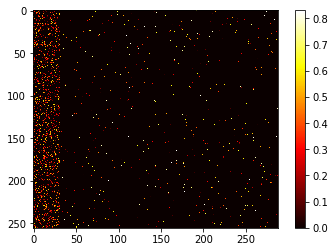

In [4]:
plt.imshow(np.abs(reservoir.weights.todense().T), cmap=plt.cm.hot);
plt.colorbar();

## Spectral radius is a measure of stability

Next consider how our reservoir responds to an impulse input, i.e., a spike in activation followed by zero inputs.

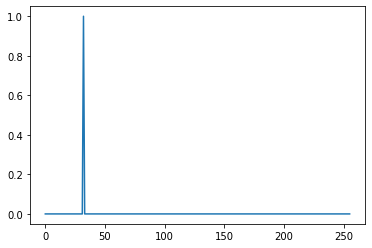

In [5]:
impulse = np.zeros((256, 1), dtype=np.float32)
impulse[32] = 1.0

plt.plot(impulse);

(-1.0, 1.0)

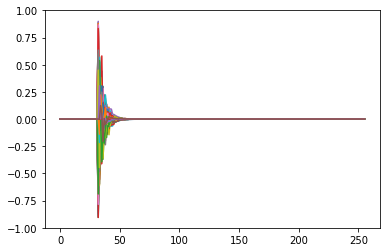

In [6]:
reservoir = EchoStateReservoir(1, 256, input_scale=1.5, res_scale=0.8)

activations, state = reservoir(impulse)

plt.plot(activations);
plt.ylim((-1.0, 1.0))

Repeate the above experiment several times for values of `res_conn` that are both small and larger than one, say 0.1-2.0.  What do you notice?

The spectral radius can be viewed as a measure of stability.  In other words, a smaller spectral radius (typically less than one) often ensures that the activations eventually settle and do not grow arbitrarily large or oscillate indefinitely.  A larger spectral radius, however, may result in an unstable network that produces activations that grow wildly after encountering an impulse.

(-1.0, 1.0)

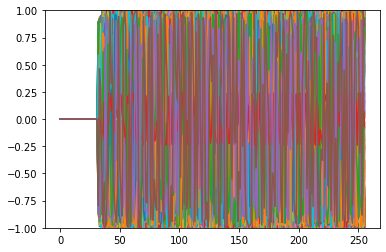

In [7]:
reservoir = EchoStateReservoir(1, 256, input_scale=1.5, res_scale=2.0)

activations, state = reservoir(impulse)

plt.plot(activations);
plt.ylim((-1.0, 1.0))

## The Echo State Property (ESP)

__Echo State Property__:  For a given reservoir and a fixed sequence of inputs, the reservoir is said to have the Echo State Property (ESP) if it will eventually converge to the same sequence of output activations for __any__ initial state.

In order to demonstrate this, consider inputs to our reservoir that consist of a simple sine wave and also that of a sine wave with perturbations at timesteps 30 and 300 

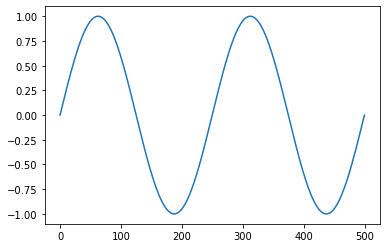

In [8]:
time = np.linspace(0, 4 * np.pi, 500)
sinusoid = np.sin(time)[:, None]

plt.plot(sinusoid);

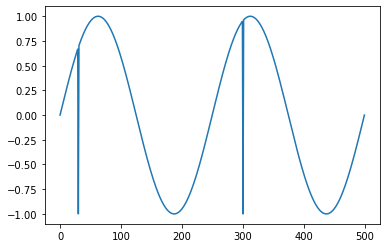

In [9]:
perturbed_sinusoid = sinusoid.copy()
perturbed_sinusoid[30] = -1.0
perturbed_sinusoid[300] = -1.0

plt.plot(perturbed_sinusoid);

And also the corresponding reservoir activations generated by these input signals, when using the same reservoir.

In [10]:
reservoir = EchoStateReservoir(1, 128, input_scale=5.0, res_scale=0.98)

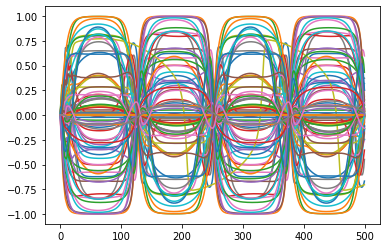

In [11]:
sin_activations, _ = reservoir(sinusoid)

plt.plot(sin_activations);

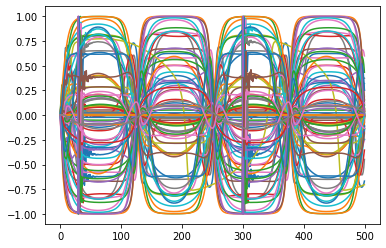

In [12]:
per_activations, _ = reservoir(perturbed_sinusoid)

plt.plot(per_activations);

Notice that the activations are exactly the same in both cases except near the perturbations!!

Having the ESP means that a networks response to a given input is localized in time and that it will consistently produce similar responses after encountering the same sequence of inputs.

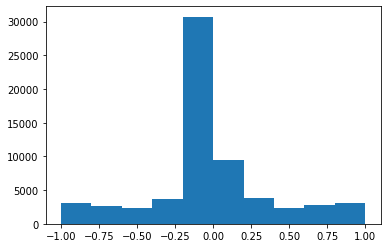

In [13]:
plt.hist(per_activations.ravel());

## The big picture

Rather than tuning the weights in an ESN, we instead rely on the reservoir having the ability to generate a sufficently rich and dynamic yet localized and consistent responses to the network's inputs.  This is achieved by:

1.  Using very large and sparse reservoirs to generate a large set of rich, loosely coupled activation responses.
1.  Scale the reservoir weights to ensure stability and achieve the ESP, which ensures that the reservoir activations will converge to the same sequence of outputs given the same sequence of inputs.
1.  Scale the input weights to adjust nonlinearity.  Larger input weights result in more nonlinear activation dynamics (more saturation of the sigmoidal activation function) while smaller input weights result in more linear behavior.

Once we have a sufficently rich yet constrained set of activations, we can use simple readout layers to combine these activations in a way that maps to the desired outputs.

## Echo State Networks for Regression

In [14]:
class EchoStateNetwork:
    def __init__(self, ninputs, nunits, **res_kwargs):
        self.reservoir = EchoStateReservoir(
            ninputs=ninputs,
            nunits=nunits,
            **res_kwargs)
        self.weights = None
        
    @staticmethod
    def _bias(data):
        new_data = np.empty(
            (data.shape[0], data.shape[1] + 1),
            dtype=data.dtype)
        new_data[:, :-1], new_data[:, -1] = data, 1.0
        return new_data
        
    def train(self, inputs, targets):        
        acts, _ = self.reservoir(inputs)
        acts1 = self._bias(acts)
        
        # this is just linear regression
        a = acts1.T @ acts1
        b = acts1.T @ targets
        self.weights = sp.linalg.pinvh(a) @ b

    def __call__(self, data):
        acts, _ = self.reservoir(data)
        return self._bias(acts) @ self.weights

## Time-Series Forecasting

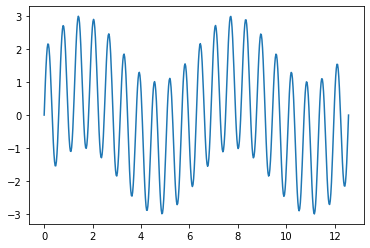

In [15]:
time = np.linspace(0, 4 * np.pi, 500)
data = (np.sin(time) + 2 * np.sin(10 * time))[:, None]
plt.plot(time, data);

In [16]:
esn = EchoStateNetwork(1, 256)

esn.train(data[:-1], data[1:])

In [17]:
result = esn(data)
result.shape

(500, 1)

In [18]:
result.shape, data.shape

((500, 1), (500, 1))

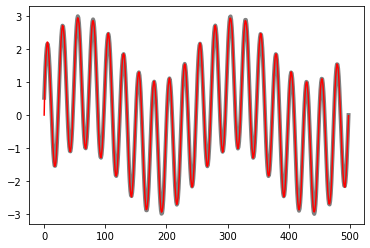

In [19]:
plt.plot(data[1:], linewidth=4, color='grey');
plt.plot(result[:-1], color='red');

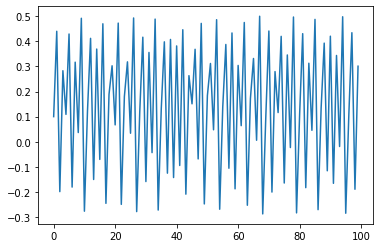

In [20]:
def gauss_map(n, a=6.2, b=-0.5):                                                                                   
    s = np.empty(n)                                                                                
    s[0] = 0.1                                                                                     
    for i in range(1, n):                                                                           
        s[i] = np.exp(-a * s[i-1]**2) + b
    
    return s[:, None]

chaotic_signal_train = gauss_map(1024)
chaotic_signal_test = gauss_map(100)

plt.plot(chaotic_signal_test);

In [21]:
esn = EchoStateNetwork(1, 1024, input_scale=7.0, res_scale=0.95)

esn.train(chaotic_signal_train[:-1], chaotic_signal_train[1:])

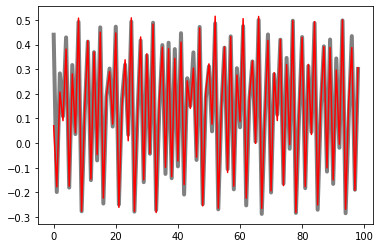

In [22]:
result = esn(chaotic_signal_test)

plt.plot(chaotic_signal_test[1:], linewidth=4, color='grey');
plt.plot(result[:-1], color='red');

(array([ 41828.,  50369.,  98793., 149568., 185279., 185814., 145269.,
         99827.,  51436.,  40393.]),
 array([-9.9930e-01, -7.9941e-01, -5.9953e-01, -3.9965e-01, -1.9977e-01,
         1.1796e-04,  2.0000e-01,  3.9988e-01,  5.9977e-01,  7.9965e-01,
         9.9953e-01], dtype=float32),
 <a list of 10 Patch objects>)

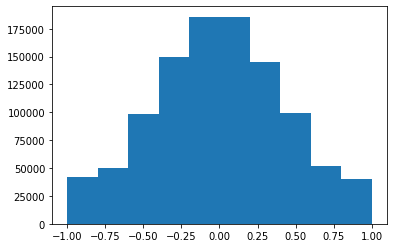

In [23]:
activations, _ = esn.reservoir(chaotic_signal_train)

plt.hist(activations.ravel())

## Solving The Temporal XOR Problem

In [24]:
def temporal_xor(n, shift):
    bits = np.random.random((n, 1)) > 0.5
    shifted_bits = np.concatenate((bits[:shift], bits))[:-shift]
    txor_bits = np.bitwise_xor(bits, shifted_bits)
    return bits.astype(np.float32), txor_bits.astype(np.float32)

In [25]:
bits, txor_bits = temporal_xor(6, 2)

In [26]:
def plot_bits(bits1, bits2, title=None):
    bits = np.hstack((bits1, bits2))
    
    fig = plt.figure()
    
    for i in range(2):
        color = 'red' if i else 'blue'
        ax = fig.add_subplot(2, 1, i+1)
        ax.bar(range(bits[:, i].size), bits[:, i], width=1.0, color=color)
        if i == 0 and title:
            ax.set_title(title)
        ax.set_ylabel('Value')
        if i == 1:
            ax.set_xlabel('Timestep')
        ax.autoscale(tight=True)
        ax.set_ylim((-0.1, 1.1))

In [27]:
inputs, targets = temporal_xor(512, 5)
inputs.shape, targets.shape

((512, 1), (512, 1))

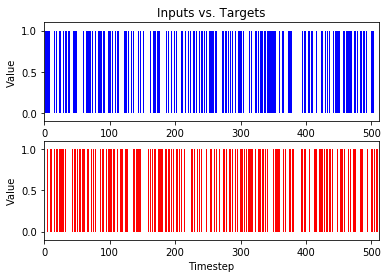

In [28]:
plot_bits(inputs, targets, 'Inputs vs. Targets');

In [29]:
esn_txor = EchoStateNetwork(ninputs=1, nunits=2048, input_scale=2.0, res_scale=0.95)
esn_txor.train(inputs, targets)

In [30]:
predictions = esn_txor(inputs)

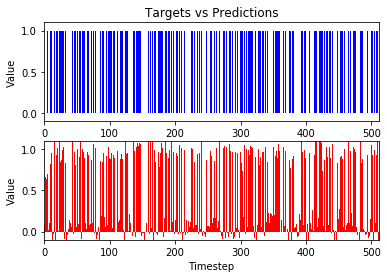

In [31]:
plot_bits(targets, predictions, 'Targets vs Predictions')

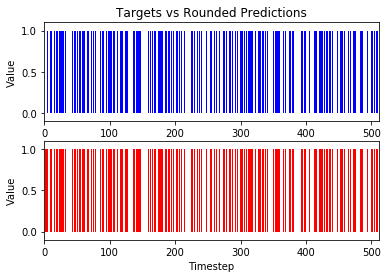

In [32]:
plot_bits(targets, np.round(predictions), 'Targets vs Rounded Predictions')

(array([ 22009.,  31827.,  82723., 158783., 229209., 225544., 158949.,
         83267.,  33657.,  22608.]),
 array([-9.9540e-01, -7.9628e-01, -5.9717e-01, -3.9805e-01, -1.9893e-01,
         1.8299e-04,  1.9930e-01,  3.9842e-01,  5.9753e-01,  7.9665e-01,
         9.9576e-01], dtype=float32),
 <a list of 10 Patch objects>)

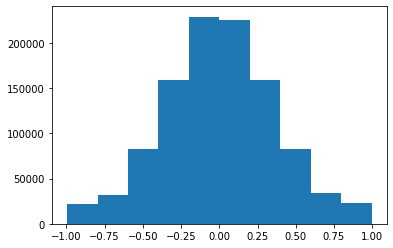

In [33]:
activations, _ = esn_txor.reservoir(inputs)

plt.hist(activations.ravel())

References:
1.  [Echo State Network](http://www.scholarpedia.org/article/Echo_state_network).  Herbert Jaeger, Scholarpedia, Jacobs University Bremen, Bremen, Germany.
1.  [Jaeger H. Adaptive nonlinear system identification with echo state networks](http://papers.nips.cc/paper/2318-adaptive-nonlinear-system-identification-with-echo-state-networks.pdf). InAdvances in neural information processing systems 2003 (pp. 609-616).
1.  [Echo State Networks for Modeling and Classification of EEG Signals in Mental-Task Brain Computer Interfaces](https://www.elliottforney.com/wp-content/uploads/forney2015echo.pdf).  Elliott M. Forney, Charles W. Anderson, William J. Gavin, Patricia L. Davies, Marla C. Roll, Brittany K. Taylor, (2015) Technical Report, Department of Computer Science, Colorado State University, Fort Collins, CO.
1.  [CEBL3](https://github.com/idfah/cebl).  Elliott M. Forney, Charles W. Anderson.  Open-source software project.  Colorado State University, Department of Computer Science, 2012.
1.  [Introduction to Recurrent Networks and Applications in EEG Analysis](https://www.elliottforney.com/blog/recurrent-nets-and-eeg/).  Invited lecture in a course on Advanced Machine Learning at Colorado State University, Department of Computer Science, 2016.
1.  [A Stimulus-Free Brain-ComputerInterface using Mental Tasks and Echo State Networks](https://www.elliottforney.com/wp-content/uploads/bciposter2013stimulus.pdf).  Elliott Forney, Charles Anderson, William Gavin, Patricia Davies.  Presented at The International BCI Meeting, June 3-7, 2013, Pacific Grove, California.  Poster.  Winner of Best Overall Poster Award.
1.  [Non-Invasive Brain-Computer Interfaces using Echo State Networks](https://www.elliottforney.com/wp-content/uploads/mcinposter2012noninvasive.pdf).  Elliott Forney, Charles Anderson, William Gavin, Patricia Davies, Brittany Taylor and Marla Roll.  Presented at the Front Range Neuroscience Group (FRNG) Annual Meeting, November 28th, 2012, Fort Collins, Colorado. Poster.
1.  [A Comparison of Elman and Echo State Recurrent Neural Networks](https://www.elliottforney.com/wp-content/uploads/ccwicposter2010comparison.pdf).  Elliott Forney and Charles Anderson.  Presented at the Colorado Celebration of Women in Computing (CCWIC) Annual Symposium, November 4th, 2010, Golden Colorado.  Poster.